<a href="https://colab.research.google.com/github/NHCh1/DLI/blob/main/DLI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [56]:
import numpy as np
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import time
import os

# Data Loading

In [2]:
url = 'https://raw.githubusercontent.com/NHCh1/DLI/refs/heads/main/Dli-mendeley_18.csv'
data = pd.read_csv(url, header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1,1,50,0,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,2,1,4,59,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,2,1,4,57,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,3,1,1,49,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


# Pre-processing

In [3]:
#Array of features
x = data.drop([48], axis=1)
print(x)

#Array of target
y = data[48]
print(y)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

In [4]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [5]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print('------------------------------------------------------------------')
print(x_test)

[[ 0.4264587  -0.76932106 -0.15488093 ...  0.39933321 -0.23638944
   0.76186885]
 [-1.06951269 -0.76932106 -0.69750681 ...  0.39933321  1.0884513
   0.76186885]
 [ 1.92243009  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
  -1.47048024]
 [-0.32152699  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  0.38774495 ...  0.39933321  1.0884513
   0.76186885]]
------------------------------------------------------------------
[[-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
   0.76186885]
 [ 9.40228702  0.5460789   0.38774495 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  2.0156226  ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [ 0.4264587   0.5460789  -1.2401327  ... -1.51922032 -1.56123018
  -0.35430569]
 [-1.06951269 -0.76932106 -1.78275858 ...  0.39933321 -0.23638944
  -0.35430569]
 [-0.32152699  0.5460789  -0.154880

# Model Training

## XGBoost

Defining XGBoost Model

In [6]:
xgb_basic = XGBClassifier(eval_metric='error',
                          use_label_encoder=False,
                          n_jobs=-1,
                          random_state=42,
                          verbosity=0
                          )

Performing feature selection in XGBoost

In [7]:
selector = RFECV(xgb_basic, cv=5, n_jobs=-1)
selector.fit(x, y)

selected_cols = np.where(selector.ranking_ == 1)[0]
print(f"Selected feature indices: {selected_cols}")

xgb_pipe = make_pipeline(ColumnSelector(cols=selected_cols),
                         XGBClassifier(eval_metric='error',
                                       use_label_encoder=False,
                                       n_jobs=-1,
                                       random_state=42
                                       )
                         )

xgb_pipe.fit(x_train, y_train)
xgb_pipe_train = xgb_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_pipe_test = xgb_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
xgb_pipe_accuracy = xgb_pipe.score(x_test, y_test)
print(f"Accuracy: {xgb_pipe_accuracy:.8f}")

Selected feature indices: [ 0  1  2  3  4  5  8  9 10 11 13 14 15 18 20 21 22 24 25 26 27 28 29 30
 31 32 33 34 38 39 40 41 45 46 47]
Accuracy: 0.98433333


Finding best hyperparameters and best threshold in XGBoost

In [8]:
param_dist = {'xgbclassifier__max_depth': [4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
              'xgbclassifier__n_estimators': [1000, 2000, 3000],
              'xgbclassifier__subsample': [0.7, 0.8, 0.9],
              'xgbclassifier__colsample_bytree': [0.7, 0.8, 0.9],
              'xgbclassifier__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]
              }

xgb_search = RandomizedSearchCV(xgb_pipe,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=5,
                                n_jobs=-1,
                                scoring='accuracy',
                                verbose=1
                                )

xgb_search.fit(x_train, y_train)
print("Best Hyperparameters:", xgb_search.best_params_)

xgb_model = xgb_search.best_estimator_
xgb_probs = xgb_model.predict_proba(x_test)[:, 1]
xgb_model_train = xgb_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_model_test = xgb_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

thresholds = [i / 100 for i in range(1, 100)]
best_acc, best_thresh = 0, 0

for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_thresh = acc, t

print(f"Best Threshold: {best_thresh:.4f}, Best Accuracy: {best_acc:.8f}")
xgb_final_pred = (xgb_probs >= best_thresh).astype(int)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'xgbclassifier__subsample': 0.9, 'xgbclassifier__scale_pos_weight': 1.006305531670966, 'xgbclassifier__n_estimators': 2000, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__colsample_bytree': 0.9}
Best Threshold: 0.5000, Best Accuracy: 0.98533333


XGBoost Model Training Result

In [57]:
xgb_acc     = accuracy_score(y_test, xgb_final_pred)
xgb_prec    = precision_score(y_test, xgb_final_pred)
xgb_rec     = recall_score(y_test, xgb_final_pred)
xgb_f1      = f1_score(y_test, xgb_final_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs)

xgb_pipe_prob = xgb_pipe.predict_proba(x_test)[:, 1]
xgb_pipe_pred = (xgb_pipe_test >= 0.5).astype(int)

print("Final Xgb Model Metrics")
print(f"Accuracy  : {xgb_acc:.4f}")
print(f"Precision : {xgb_prec:.4f}")
print(f"Recall    : {xgb_rec:.4f}")
print(f"F1-score  : {xgb_f1:.4f}")
print(f"ROC-AUC   : {xgb_roc_auc:.4f}")

start_time = time.time()
_ = xgb_model.predict_proba(x_test)
end_time = time.time()
xgb_inference_time = end_time - start_time
xgb_avg_time = xgb_inference_time / len(x_test)
print(f"Total Inference time: {xgb_inference_time:.8f}s")
print(f"Average per sample     : {xgb_avg_time:.8f}s")


Final Xgb Model Metrics
Accuracy  : 0.9853
Precision : 0.9822
Recall    : 0.9887
F1-score  : 0.9855
ROC-AUC   : 0.9982
Total Inference time: 0.11714339s
Average per sample     : 0.00003905s


## CNN Complex

Reshape data from 2D to 3D

In [10]:
x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Defining CNN Complex Model

In [11]:
def cnn_complex_tabular():
    model = Sequential()
    model.add(Input(shape=(48, 1)))
    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 7, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

cnn_model = cnn_complex_tabular()

Training CNN Complex Model

In [12]:
cnn_model.fit(x_train_cnn, y_train, epochs=25, batch_size=256, verbose=0)
cnn_model_train = cnn_model.predict(x_train_cnn)
cnn_model_test = cnn_model.predict(x_test_cnn)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


CNN Complex Training Result

In [13]:
cnn_probs = cnn_model.predict(x_test_cnn, verbose=0).ravel()
cnn_y_pred = (cnn_probs >= 0.5).astype(int)

cnn_accuracy = accuracy_score(y_test, cnn_y_pred)
cnn_precision = precision_score(y_test, cnn_y_pred)
cnn_recall = recall_score(y_test, cnn_y_pred)
cnn_f1 = f1_score(y_test, cnn_y_pred)
cnn_roc_auc = roc_auc_score(y_test, cnn_probs)

print(f"CNN Complex Model Metrics:")
print(f"Accuracy:  {cnn_accuracy:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall:    {cnn_recall:.4f}")
print(f"F1-score:  {cnn_f1:.4f}")
print(f"ROC-AUC:   {cnn_roc_auc:.4f}")

CNN Complex Model Metrics:
Accuracy:  0.9677
Precision: 0.9682
Recall:    0.9676
F1-score:  0.9679
ROC-AUC:   0.9943


## Gradient Boosting

Defining Gradient Boosting Model

In [14]:
gbc_model = GradientBoostingClassifier(max_depth=4, learning_rate=0.7)

Training Gradient Boosting Model

In [15]:
gbc_model.fit(x_train, y_train)
gbc_model_full = copy.deepcopy(gbc_model)

gbc_model_train = gbc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_model_test = gbc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

gbc_model_accuracy = gbc_model.score(x_test, y_test)
print(f"Gbc Plain Accuracy: {gbc_model_accuracy:.8f}")

Gbc Plain Accuracy: 0.98300000


Performing feature selection in Gradient Boosting

In [16]:
selector = RFECV(gbc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
gbc_col = np.where(selector.ranking_==1)[0]
print(gbc_col)

gbc_pipe = make_pipeline(ColumnSelector(cols=gbc_col), gbc_model)

gbc_pipe.fit(x_train, y_train)
gbc_pipe_train = gbc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_pipe_test = gbc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
gbc_pipe_accuracy = gbc_pipe.score(x_test, y_test)
print(f"Gbc Pipe Accuracy: {gbc_pipe_accuracy:.8f}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 16 17 20 21 22 23 24 25 26 27
 28 29 30 31 33 34 38 39 40 41 45 46 47]
Gbc Pipe Accuracy: 0.98500000


Gradient Boosting Training Result

In [17]:
gbc_pipe_prob = gbc_pipe.predict_proba(x_test)[:, 1]
gbc_pipe_pred = (gbc_pipe_test >= 0.5).astype(int)

gbc_accuracy = accuracy_score(y_test, gbc_pipe_pred)
gbc_precision = precision_score(y_test, gbc_pipe_pred)
gbc_recall = recall_score(y_test, gbc_pipe_pred)
gbc_f1 = f1_score(y_test, gbc_pipe_pred)
gbc_roc_auc = roc_auc_score(y_test, gbc_pipe_prob)

print(f"\nGbc Final Model Metrics:")
print(f"Accuracy:  {gbc_accuracy:.4f}")
print(f"Precision: {gbc_precision:.4f}")
print(f"Recall:    {gbc_recall:.4f}")
print(f"F1-score:  {gbc_f1:.4f}")
print(f"ROC-AUC:   {gbc_roc_auc:.4f}")


Gbc Final Model Metrics:
Accuracy:  0.9850
Precision: 0.9835
Recall:    0.9868
F1-score:  0.9851
ROC-AUC:   0.9982


## Decision Tree

Defining Decision Tree Model

In [18]:
dtc_model = DecisionTreeClassifier(max_depth=12)

Training Decision Tree Model

In [19]:
dtc_model.fit(x_train, y_train)
dtc_model_full = copy.deepcopy(dtc_model)

dtc_model_train = dtc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_model_test = dtc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

dtc_model_accuracy = dtc_model.score(x_test, y_test)
print(f"Dtc Plain Accuracy: {dtc_model_accuracy:.8f}")

Dtc Plain Accuracy: 0.96700000


Performing Feature Selection in Decision Tree Classifier

In [20]:
selector = RFECV(dtc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
dtc_col = np.where(selector.ranking_==1)[0]
print(dtc_col)

dtc_pipe = make_pipeline(ColumnSelector(cols=dtc_col), dtc_model)

dtc_pipe.fit(x_train, y_train)
dtc_pipe_train = dtc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_pipe_test = dtc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
dtc_pipe_accuracy = dtc_pipe.score(x_test, y_test)
print(f"Dtc Pipe Accuracy: {dtc_pipe_accuracy:.8f}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Dtc Pipe Accuracy: 0.96700000


Decision Tree Training Result

In [21]:
dtc_pipe_prob = dtc_pipe.predict_proba(x_test)[:, 1]
dtc_pipe_pred = (dtc_pipe_test >= 0.5).astype(int)

dtc_accuracy = accuracy_score(y_test, dtc_pipe_pred)
dtc_precision = precision_score(y_test, dtc_pipe_pred)
dtc_recall = recall_score(y_test, dtc_pipe_pred)
dtc_f1 = f1_score(y_test, dtc_pipe_pred)
dtc_roc_auc = roc_auc_score(y_test, dtc_pipe_prob)

print(f"Dtc Final Model Metrics:")
print(f"Accuracy:  {dtc_accuracy:.4f}")
print(f"Precision: {dtc_precision:.4f}")
print(f"Recall:    {dtc_recall:.4f}")
print(f"F1-score:  {dtc_f1:.4f}")
print(f"ROC-AUC:   {dtc_roc_auc:.4f}")

Dtc Final Model Metrics:
Accuracy:  0.9677
Precision: 0.9621
Recall:    0.9742
F1-score:  0.9681
ROC-AUC:   0.9612


## Stacked Model

In [22]:
stacked_train = np.hstack([xgb_pipe_train, cnn_model_train, gbc_pipe_train, dtc_pipe_train])
stacked_test = np.hstack([xgb_pipe_test, cnn_model_test, gbc_pipe_test, dtc_pipe_test])


stack_model = LogisticRegression(class_weight='balanced', random_state=42)
stack_model.fit(stacked_train, y_train)

y_pred = stack_model.predict(stacked_test)
stack_accuracy = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {stack_accuracy:.8f}")

Stacked Model Accuracy: 0.98433333


Stacked Model Training Result

In [23]:
stack_pred = stack_model.predict(stacked_test)
stack_prob = stack_model.predict_proba(stacked_test)[:, 1]

stack_accuracy = accuracy_score(y_test, stack_pred)
stack_precision = precision_score(y_test, stack_pred)
stack_recall = recall_score(y_test, stack_pred)
stack_f1 = f1_score(y_test, stack_pred)
stack_roc_auc = roc_auc_score(y_test, stack_prob)

print(f"Stack Final Model Metrics:")
print(f"Accuracy:  {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall:    {stack_recall:.4f}")
print(f"F1-score:  {stack_f1:.4f}")
print(f"ROC-AUC:   {stack_roc_auc:.4f}")

Stack Final Model Metrics:
Accuracy:  0.9843
Precision: 0.9822
Recall:    0.9868
F1-score:  0.9845
ROC-AUC:   0.9984


# Evaluation

## XGBoost

Classification report

In [24]:
print(classification_report(y_test, xgb_final_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9885    0.9819    0.9852      1489
           1     0.9822    0.9887    0.9855      1511

    accuracy                         0.9853      3000
   macro avg     0.9854    0.9853    0.9853      3000
weighted avg     0.9854    0.9853    0.9853      3000



Dictionary of TP, TN, FP, FN

In [25]:
xgb_y_pred = xgb_model.predict(x_test)
xgb_comparison = pd.DataFrame({'xgb_y_pred': xgb_y_pred, 'y_test': y_test})
xgb_true_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 0)).sum()
print(f"True Positive: {xgb_true_positive}")
xgb_true_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 1)).sum()
print(f"True Negative: {xgb_true_negative}")
xgb_false_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 1)).sum()
print(f"False Positive: {xgb_false_positive}")
xgb_false_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 0)).sum()
print(f"False Negative: {xgb_false_negative}")

True Positive: 1462
True Negative: 1494
False Positive: 17
False Negative: 27


Confusion Matrix

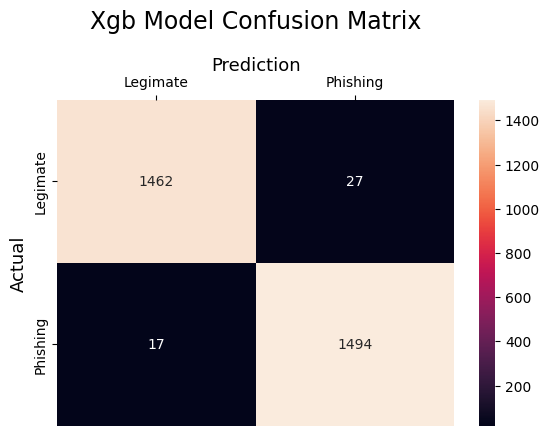

In [26]:
cm = confusion_matrix(y_test, xgb_final_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Xgb Model Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## CNN Complex

Classification Report

In [27]:
print(classification_report(y_test, cnn_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9671    0.9678    0.9674      1489
           1     0.9682    0.9676    0.9679      1511

    accuracy                         0.9677      3000
   macro avg     0.9677    0.9677    0.9677      3000
weighted avg     0.9677    0.9677    0.9677      3000



Dictionary for TP, TP, FP, FN

In [28]:
y_true = np.asarray(y_test).astype(int)
cnn_comparison = pd.DataFrame({'cnn_y_pred': cnn_y_pred, 'y_test': y_true})

cnn_true_positive = ((cnn_comparison['cnn_y_pred'] == 0) & (cnn_comparison['y_test'] == 0)).sum()
print(f"True Positive: {cnn_true_positive}")
cnn_true_negative = ((cnn_comparison['cnn_y_pred'] == 1) & (cnn_comparison['y_test'] == 1)).sum()
print(f"True Negative: {cnn_true_negative}")
cnn_false_positive = ((cnn_comparison['cnn_y_pred'] == 0) & (cnn_comparison['y_test'] == 1)).sum()
print(f"False Positive: {cnn_false_positive}")
cnn_false_negative = ((cnn_comparison['cnn_y_pred'] == 1) & (cnn_comparison['y_test'] == 0)).sum()
print(f"False Negative: {cnn_false_negative}")

True Positive: 1441
True Negative: 1462
False Positive: 49
False Negative: 48


Confusion Matrix

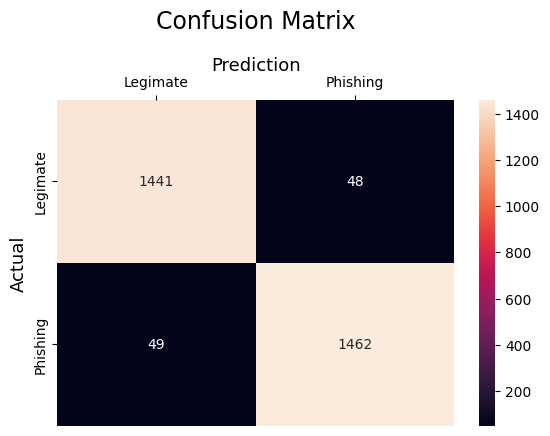

In [29]:
cm = confusion_matrix(y_test, cnn_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Gradient Boosting

Classification Report

In [30]:
print(classification_report(y_test, gbc_pipe_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9865    0.9832    0.9849      1489
           1     0.9835    0.9868    0.9851      1511

    accuracy                         0.9850      3000
   macro avg     0.9850    0.9850    0.9850      3000
weighted avg     0.9850    0.9850    0.9850      3000



Dictionary of TP, TN, FP, FN

In [31]:
gbc_y_pred = gbc_pipe.predict(x_test)
gbc_comparison = pd.DataFrame({'gbc_y_pred': gbc_y_pred, 'y_test': y_test})
gbc_true_positive = ((gbc_comparison['gbc_y_pred'] == 0) & (gbc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {gbc_true_positive}")
gbc_true_negative = ((gbc_comparison['gbc_y_pred'] == 1) & (gbc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {gbc_true_negative}")
gbc_false_positive = ((gbc_comparison['gbc_y_pred'] == 0) & (gbc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {gbc_false_positive}")
gbc_false_negative = ((gbc_comparison['gbc_y_pred'] == 1) & (gbc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {gbc_false_negative}")

True Positive: 1464
True Negative: 1491
False Positive: 20
False Negative: 25


Confusion Matrix

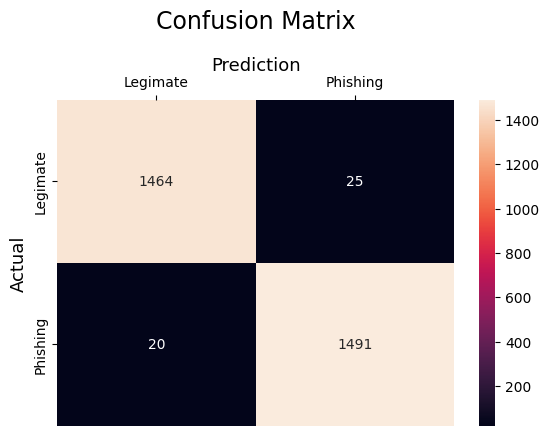

In [32]:
cm = confusion_matrix(y_test, gbc_pipe_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Decision Tree

Classification report

In [33]:
dtc_y_pred = dtc_pipe.predict(x_test)
print(classification_report(y_test, dtc_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9721    0.9610    0.9666      1489
           1     0.9620    0.9729    0.9674      1511

    accuracy                         0.9670      3000
   macro avg     0.9671    0.9670    0.9670      3000
weighted avg     0.9671    0.9670    0.9670      3000



Dictionary of TP, TN, FP, FN

In [34]:
dtc_comparison = pd.DataFrame({'dtc_y_pred': dtc_y_pred, 'y_test': y_test})

dtc_true_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {dtc_true_positive}")
dtc_true_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {dtc_true_negative}")
dtc_false_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {dtc_false_positive}")
dtc_false_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {dtc_false_negative}")

True Positive: 1431
True Negative: 1470
False Positive: 41
False Negative: 58


Confusion Matrix

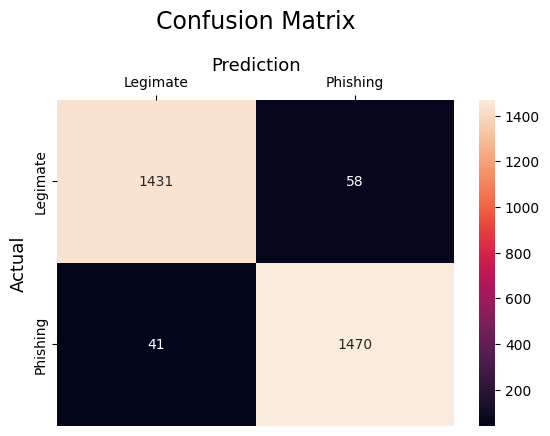

In [35]:
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Stack Model

Classification Report

In [36]:
stack_pred = stack_model.predict(stacked_test)
print(classification_report(y_test, stack_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9865    0.9819    0.9842      1489
           1     0.9822    0.9868    0.9845      1511

    accuracy                         0.9843      3000
   macro avg     0.9844    0.9843    0.9843      3000
weighted avg     0.9843    0.9843    0.9843      3000



Dictionary of TP, TN, FP, FN

In [37]:
stack_comparison = pd.DataFrame({'stack_pred': stack_pred, 'y_test': y_test})

stack_true_positive = ((stack_comparison['stack_pred'] == 0) & (stack_comparison['y_test'] == 0)).sum()
print(f"True Positive: {stack_true_positive}")
stack_true_negative = ((stack_comparison['stack_pred'] == 1) & (stack_comparison['y_test'] == 1)).sum()
print(f"True Negative: {stack_true_negative}")
stack_false_positive = ((stack_comparison['stack_pred'] == 0) & (stack_comparison['y_test'] == 1)).sum()
print(f"False Positive: {stack_false_positive}")
stack_false_negative = ((stack_comparison['stack_pred'] == 1) & (stack_comparison['y_test'] == 0)).sum()
print(f"False Negative: {stack_false_negative}")

True Positive: 1462
True Negative: 1491
False Positive: 20
False Negative: 27


Confusion Matrix

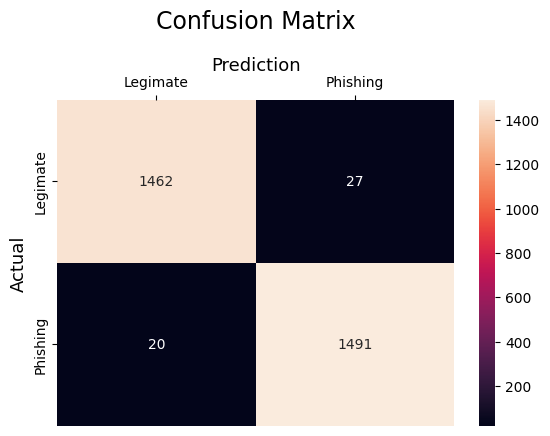

In [38]:
cm = confusion_matrix(y_test, stack_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## ROC Curve & PR Curve

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


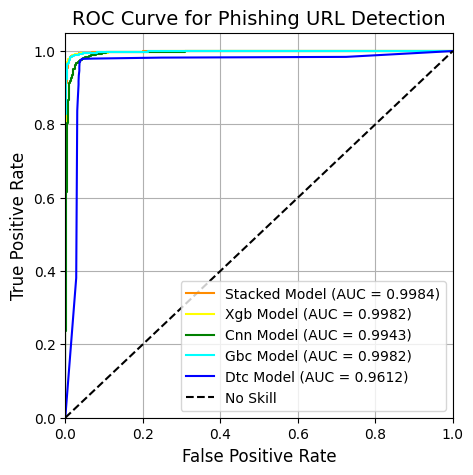

In [39]:
y_prob_stack = stack_model.predict_proba(stacked_test)[:, 1]
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_prob_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)
y_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
y_prob_cnn = cnn_model.predict(x_test_cnn)
y_prob_cnn = y_prob_cnn.ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
y_prob_gbc = gbc_pipe.predict_proba(x_test)[:, 1]
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, y_prob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
y_prob_dtc = dtc_pipe.predict_proba(x_test)[:, 1]
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, y_prob_dtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

plt.figure(figsize=(5, 5))
plt.plot(fpr_stack, tpr_stack, label='Stacked Model (AUC = %0.4f)' % roc_auc_stack, color='darkorange')
plt.plot(fpr_xgb, tpr_xgb, label='Xgb Model (AUC = %0.4f)' % roc_auc_xgb, color='yellow')
plt.plot(fpr_cnn, tpr_cnn, label='Cnn Model (AUC = %0.4f)' % roc_auc_cnn, color='green')
plt.plot(fpr_gbc, tpr_gbc, label='Gbc Model (AUC = %0.4f)' % roc_auc_gbc, color='cyan')
plt.plot(fpr_dtc, tpr_dtc, label='Dtc Model (AUC = %0.4f)' % roc_auc_dtc, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Phishing URL Detection', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

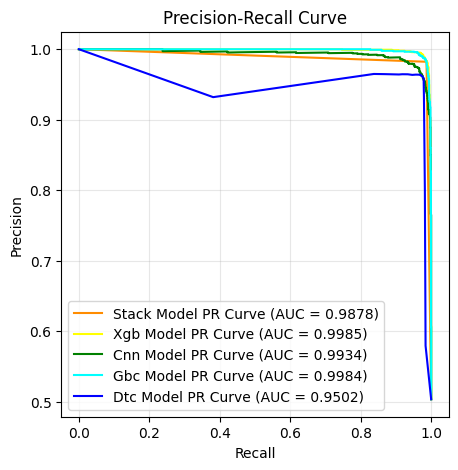

In [40]:
# Precision-Recall Curve
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_test, y_pred)
auc_score_stack = auc(recall_stack, precision_stack)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, xgb_probs)
auc_score_xgb = auc(recall_xgb, precision_xgb)
y_prob_cnn = cnn_model_test.ravel()
precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_test, y_prob_cnn)
auc_score_cnn = auc(recall_cnn, precision_cnn)
precision_gbc, recall_gbc, thresholds_gbc = precision_recall_curve(y_test, gbc_pipe_prob)
auc_score_gbc = auc(recall_gbc, precision_gbc)
precision_dtc, recall_dtc, thresholds_dtc = precision_recall_curve(y_test, dtc_pipe_prob)
auc_score_dtc = auc(recall_dtc, precision_dtc)

plt.figure(figsize=(5, 5))
plt.plot(recall_stack, precision_stack, label=f'Stack Model PR Curve (AUC = {auc_score_stack:.4f})', color='darkorange')
plt.plot(recall_xgb, precision_xgb, label=f'Xgb Model PR Curve (AUC = {auc_score_xgb:.4f})', color='yellow')
plt.plot(recall_cnn, precision_cnn, label=f'Cnn Model PR Curve (AUC = {auc_score_cnn:.4f})', color='green')
plt.plot(recall_gbc, precision_gbc, label=f'Gbc Model PR Curve (AUC = {auc_score_gbc:.4f})', color='cyan')
plt.plot(recall_dtc, precision_dtc, label=f'Dtc Model PR Curve (AUC = {auc_score_dtc:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

XGBoost contribution weight: 4.0214
CNN contribution weight: 2.9520
GradientBoosting contribution weight: 4.2164
DecisionTree contribution weight: 2.6744


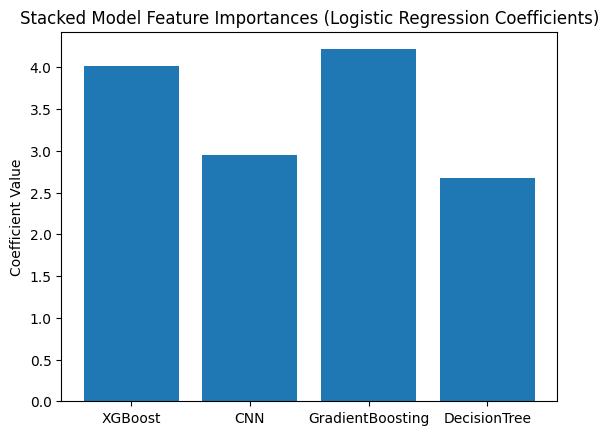

In [41]:
# Logistic Regression Coefficients
importance_scores = stack_model.coef_[0]
stacked_features = ['XGBoost', 'CNN', 'GradientBoosting', 'DecisionTree']
for name, coef in zip(stacked_features, importance_scores):
    print(f"{name} contribution weight: {coef:.4f}")

plt.bar(stacked_features, importance_scores)
plt.title('Stacked Model Feature Importances (Logistic Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()

# Save Model

Saving Final XGB Model

In [42]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

Saving Final CNN Complex Model

In [43]:
cnn_model.save('cnn_complex.h5')

Saving Final Gradient Boosting Model

In [44]:
joblib.dump(gbc_pipe, 'gbc_model.pkl')

['gbc_model.pkl']

Saving Final Decision Tree Model

In [45]:
joblib.dump(dtc_pipe, 'dtc_model.pkl')

['dtc_model.pkl']

# Prediction

# XGBoost - Liong Chi Teng - TP065355

Data processing

In [48]:
xgb_feature = data.drop([48],axis=1)
print(xgb_feature)
xgb_target = data[48]
print(xgb_target)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

Retest original paper code

In [61]:
ind_xg = XGBClassifier(use_label_encoder =False, eval_metric='logloss')
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
xgb_scores={'accuracy': make_scorer(accuracy_score),
            'recall' : make_scorer(recall_score),
            'precision':make_scorer(precision_score),
            'gmean': make_scorer(geometric_mean_score),
            'f1':make_scorer(f1_score),
            'roc': make_scorer(roc_auc_score)
            }
from sklearn.model_selection import cross_validate
ind_xg_result = cross_validate(ind_xg, xgb_feature, xgb_target, cv = 10, scoring=xgb_scores)
df = pd.DataFrame(ind_xg_result)

ori_xgb_scores = df.mean(axis=0)
ori_xgb_acc  = ori_xgb_scores['test_accuracy']
ori_xgb_prec = ori_xgb_scores['test_precision']
ori_xgb_rec  = ori_xgb_scores['test_recall']
ori_xgb_f1   = ori_xgb_scores['test_f1']
ori_xgb_roc  = ori_xgb_scores['test_roc']

df.mean(axis=0)

,0
fit_time,0.588145
score_time,0.040429
test_accuracy,0.982600
test_recall,0.980000
test_precision,0.985211
test_gmean,0.982576
test_f1,0.982559
test_roc,0.982600


Evaluating inference time and model size

In [58]:
ind_xg.fit(xgb_feature, xgb_target)

start_time = time.time()
_ = ind_xg.predict_proba(xgb_feature)
end_time = time.time()
ori_xgb_total_inference_time = end_time - start_time
ori_xgb_avg_inference_time = ori_xgb_total_inference_time / len(xgb_feature)
print(f"Total Inference time: {ori_xgb_total_inference_time:.8f} seconds")
print(f"Average per sample:     {ori_xgb_avg_inference_time:.8f} seconds")

ind_xg.save_model('ori_xgb.json')
ori_xgb_size_in_bytes = os.path.getsize('ori_xgb.json')
ori_xgb_size_in_kb = ori_xgb_size_in_bytes / 1024
print(f"Model size: {ori_xgb_size_in_kb:.2f} KB")

new_xgb_size_in_bytes = os.path.getsize('xgb_model.pkl')
new_xgb_size_in_kb = new_xgb_size_in_bytes / 1024
print(f"New Model size: {new_xgb_size_in_kb:.2f} KB")

Total Inference time: 0.03592944 seconds
Average per sample:     0.00000359 seconds
Model size: 292.28 KB
New Model size: 2740.81 KB


Side by side comparison

In [64]:
xgb_comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "Total Inference Time (s)", "Avg Inference Time (s)", "Model Size (KB)"],

    "Old (ind_xg)": [
        f"{ori_xgb_acc:.4f}",
        f"{ori_xgb_prec:.4f}",
        f"{ori_xgb_rec:.4f}",
        f"{ori_xgb_f1:.4f}",
        f"{ori_xgb_roc:.4f}",
        f"{ori_xgb_total_inference_time:.8f}",
        f"{ori_xgb_avg_inference_time:.8f}",
        f"{ori_xgb_size_in_kb:.2f}"
    ],

    "New (xgb_model)": [
        f"{xgb_acc:.4f}",
        f"{xgb_prec:.4f}",
        f"{xgb_rec:.4f}",
        f"{xgb_f1:.4f}",
        f"{xgb_roc_auc:.4f}",
        f"{xgb_inference_time:.8f}",
        f"{xgb_avg_time:.8f}",
        f"{new_xgb_size_in_kb:.2f}"
    ]
}

pd.DataFrame(xgb_comparison_data)

,Metric,Old (ind_xg),New (xgb_model)
0,Accuracy,0.9826,0.9853
1,Precision,0.9852,0.9822
2,Recall,0.9800,0.9887
3,F1-score,0.9826,0.9855
4,ROC-AUC,0.9826,0.9982
5,Total Inference Time (s),0.03592944,0.11714339
6,Avg Inference Time (s),0.00000359,0.00003905
7,Model Size (KB),292.28,2740.81


# CNN Complex - Ng Hooi Chi - TP065587

# Gradient Boosting - Lee Zhi Hui - TP074075

# Decision Tree - Ong Wing Xuan - TP065481